In [5]:
import pyspark as ps
import pyspark.sql.functions as f
from pyspark.sql.types import *
import zipfile 

spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [6]:
with zipfile.ZipFile('data/zippedData.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')


FileNotFoundError: [Errno 2] No such file or directory: 'data/zippedData.zip'

In [7]:
tweets_rdd = spark.read.json('data/french_tweets.json')

In [8]:
tweets_rdd.take(1)

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:30:45 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], type='Polygon'), country='France', country_code='FR', full_name='Dozulé, France', id='4da693e9b39923ab', name='Dozulé', place_type='city', url='https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, r

In [99]:
len(tweets_rdd.take(1))

1

In [9]:
tweets_df = tweets_rdd

In [10]:
tweets_df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [11]:
first_tweet = tweets_df.take(1)

In [12]:
tweets_df.select(tweets_df.text).take(1)

[Row(text='Je comprends pas trop la fin de 13 reasons why 😓')]

In [13]:
tweets_df.select(tweets_df.created_at).take(1)

[Row(created_at='Wed Apr 26 13:30:45 +0000 2017')]

In [14]:
tweets_df.select(tweets_df.created_at, tweets_df.text).show(5)

+--------------------+--------------------+
|          created_at|                text|
+--------------------+--------------------+
|Wed Apr 26 13:30:...|Je comprends pas ...|
|Wed Apr 26 13:30:...|@julesbl99 travai...|
|Wed Apr 26 13:30:...|@lecho_fr @lasauc...|
|Wed Apr 26 13:30:...|362 jours par an ...|
|Wed Apr 26 13:30:...|@julia71903850 От...|
+--------------------+--------------------+
only showing top 5 rows



In [15]:
tweets_df.createOrReplaceTempView('french_tweets')

query_time = '''
SELECT created_at
FROM french_tweets
LIMIT 10
'''
# to_timestamp(created_at,"EEE MMM d H:mm:ss z yyyy")
new_df = spark.sql(query_time)
new_df.show()

+--------------------+
|          created_at|
+--------------------+
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
|Wed Apr 26 13:30:...|
+--------------------+



In [16]:
tweets_df.createOrReplaceTempView('french_tweets')

query_time = '''
SELECT created_at, timestamp_ms
FROM french_tweets
LIMIT 10
'''
# to_timestamp(created_at,"EEE MMM d H:mm:ss z yyyy")
#[Row(created_at='Wed Apr 26 13:30:45 +0000 2017')]
new_df = spark.sql(query_time)
new_df_2 = new_df.selectExpr("cast(timestamp_ms as int) timestamp_ms")
new_df_2.show()

+------------+
|timestamp_ms|
+------------+
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
+------------+



In [17]:
query_time = '''
SELECT created_at, timestamp_ms
FROM french_tweets
LIMIT 10
'''

new_df = tweets_df.select(tweets_df.timestamp_ms)
new_df.show(10)

+-------------+
| timestamp_ms|
+-------------+
|1493213445345|
|1493213445337|
|1493213446307|
|1493213446992|
|1493213447227|
|1493213447183|
|1493213447896|
|1493213448440|
|1493213448647|
|1493213449972|
+-------------+
only showing top 10 rows



In [18]:
new_df_2.createOrReplaceTempView('time_test')

query_time_int = '''
    SELECT timestamp_ms
    FROM time_test
    WHERE timestamp_ms > 1493213449972
    LIMIT 10
    '''

time_test_df = spark.sql(query_time_int)
time_test_df.show()

+------------+
|timestamp_ms|
+------------+
+------------+



In [19]:
def load_data(fname):
    '''Initiates an RDD  created from the file provided.
    
    Parameters
    ----------
    fname (str): a string of the path to the file
    
    Returns
    -------
    file_rdd: RDD of the file
    
    '''
    sc = spark.sparkContext
    file_rdd = sc.textFile(fname)
    return file_rdd

In [20]:
import json
def parse_json_first_key_pair(json_string):
    """Returns the first (key,value) pair from a json encoded dictionary.

    Parameters
    ----------
    json_string (str): a string encoding a json dictionary

    Returns
    -------
    [k,v]: the first key (k) and value (v) pair in the input json dict

    Example
    -------
    >>> parse_json_first_key_pair(u'{"Jane": "2"}')
    (u'Jane', 2)
    """
    try: 
        json_obj = json.loads(json_string)
        k = 'text'
        text = json_obj[k]
    except:
        text = ''
    return text


In [96]:
tweets_rdd = load_data('data/french_tweets.json')
parsed_rdd = tweets_rdd.map(lambda row: parse_json_first_key_pair(row))
parsed_rdd.take(10)

['Je comprends pas trop la fin de 13 reasons why 😓',
 '@julesbl99 travailles au lieu de raconter ta vie',
 "@lecho_fr @lasaucelleoff J'espère faire mieux mais c'est pas sûr dieu seul le sait",
 "362 jours par an je suis adorable, aujourd'hui ne fait pas parti de ces 362.... 😡😡",
 '@julia71903850 Отличная реклама!',
 "La macronie En Marche ! commence déjà à s'écharper avant d'avoir commencé :\n\nhttps://t.co/9f4YhjMFaG",
 '#AllEyezOnIt #Neochrome #Eriah #Loin #Youtube #YoutubeNeochrome #RepDom cc @neochromeprod… https://t.co/UymjEOk2Py',
 "#RNCMobile 8545:21 captée https://t.co/tHXf3GhYGu mais j'ai mal mis M8 on peut corriger? @MCCob @CMawasaki",
 '@lxcasjkr @Pearja_ Ca Fait 3 fois je replay je vois pas',
 '@1001portails Mais ou va ce monde! : Un robot chargé de la sécurité dans la Silicon Valley passé à tabac (par slate.fr)']

In [97]:
type(tweets_rdd)

pyspark.rdd.RDD

In [92]:
split_rdd = parsed_rdd.flatMap(lambda row: row.split(' '))
split_rdd.take(10)
tweets_rdd.count()

216912

In [23]:
handle_rdd = split_rdd.filter(lambda row: row.startswith('@'))
handle_rdd.take(13)

['@julesbl99',
 '@lecho_fr',
 '@lasaucelleoff',
 '@julia71903850',
 '@neochromeprod…',
 '@MCCob',
 '@CMawasaki',
 '@lxcasjkr',
 '@Pearja_',
 '@1001portails',
 '@XxM0hawkPuppyXx',
 '@Moorlands2',
 '@NXR90']

In [24]:
lst = []
for i in range(14):
    try:
        handle_rdd.take(i)
        x = i
    except: x = ''
    lst.append(x)
print(lst)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [25]:
tweets_rdd.take(13)[-1]

'{"created_at":"Wed Apr 26 13:30:52 +0000 2017","id":857225468659068929,"id_str":"857225468659068929","text":"Il  b\\u00e9gaye comme un petit qui s\'est fait voler son go\\u00fbter j\'suis cuit  https:\\/\\/t.co\\/BmoKusoEfy","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/iphone\\" rel=\\"nofollow\\"\\u003eTwitter for iPhone\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":914331169,"id_str":"914331169","name":"doublev\\u00e9-haine-bae","screen_name":"Raf_Heddid","location":"Chambre 117","url":null,"description":null,"protected":false,"verified":false,"followers_count":182,"friends_count":73,"listed_count":23,"favourites_count":6656,"statuses_count":38352,"created_at":"Tue Oct 30 10:18:44 +0000 2012","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":"fr","contributors_enabled":false,"is_translator":false,"prof

In [26]:
parsed_rdd.take(13)

['Je comprends pas trop la fin de 13 reasons why 😓',
 '@julesbl99 travailles au lieu de raconter ta vie',
 "@lecho_fr @lasaucelleoff J'espère faire mieux mais c'est pas sûr dieu seul le sait",
 "362 jours par an je suis adorable, aujourd'hui ne fait pas parti de ces 362.... 😡😡",
 '@julia71903850 Отличная реклама!',
 "La macronie En Marche ! commence déjà à s'écharper avant d'avoir commencé :\n\nhttps://t.co/9f4YhjMFaG",
 '#AllEyezOnIt #Neochrome #Eriah #Loin #Youtube #YoutubeNeochrome #RepDom cc @neochromeprod… https://t.co/UymjEOk2Py',
 "#RNCMobile 8545:21 captée https://t.co/tHXf3GhYGu mais j'ai mal mis M8 on peut corriger? @MCCob @CMawasaki",
 '@lxcasjkr @Pearja_ Ca Fait 3 fois je replay je vois pas',
 '@1001portails Mais ou va ce monde! : Un robot chargé de la sécurité dans la Silicon Valley passé à tabac (par slate.fr)',
 '@XxM0hawkPuppyXx @Moorlands2 Many thanks for the Likes',
 'Envie de participer à un tournoi entreprise 4x4 de beach-volley à Montpellier?\nTéléchargez la plaque

In [27]:
split_rdd.count()

2460137

In [28]:
handle_rdd.count()

148052

In [29]:
kv_rdd = handle_rdd.map(lambda x: (x, 1))
kv_rdd.take(10)
#     .groupByKey()\
#     .mapValues(lambda vals: len(set(vals)))\
#     .sortByKey()\
#     .collect()
# #[(datetime.date(1995, 8, 1), 2),
# # (datetime.date(1995, 8, 2), 2),
# # (datetime.date(1995, 8, 3), 2),
# # (datetime.date(1995, 8, 4), 1),
# # (datetime.date(1995, 8, 5), 1)]

[('@julesbl99', 1),
 ('@lecho_fr', 1),
 ('@lasaucelleoff', 1),
 ('@julia71903850', 1),
 ('@neochromeprod…', 1),
 ('@MCCob', 1),
 ('@CMawasaki', 1),
 ('@lxcasjkr', 1),
 ('@Pearja_', 1),
 ('@1001portails', 1)]

In [30]:
kv_count_rdd = kv_rdd.reduceByKey(lambda a,b: a + b)
kv_count_rdd.take(10)

[('@lasaucelleoff', 1),
 ('@Francois_Ruffin', 77),
 ('@Francois_Ruffin:', 2),
 ('@Cnews', 10),
 ('@MLP_officiel', 1215),
 ('@lozzycupcake', 2),
 ('@TMobileHelp', 1),
 ('@KonbiniFr', 12),
 ('@A_Addams_', 14),
 ('@UoNSportRehab', 1)]

In [31]:
kv_count_rdd.count()

56971

In [32]:
sorted_count_rdd = kv_count_rdd.sortBy(lambda x: x[1], ascending=False)
sorted_count_rdd.take(10)

[('@', 5252),
 ('@EmmanuelMacron', 1898),
 ('@MLP_officiel', 1215),
 ('@TPMP', 815),
 ('@Cyrilhanouna', 616),
 ('@BFMTV', 606),
 ('@JLMelenchon', 504),
 ('@dupontaignan', 389),
 ('@GG_RMC', 363),
 ('@…', 274)]

In [79]:
lst = sorted_count_rdd.take(15)

In [80]:
print(type(lst))
print(lst)

<class 'list'>
[('@', 5252), ('@EmmanuelMacron', 1898), ('@MLP_officiel', 1215), ('@TPMP', 815), ('@Cyrilhanouna', 616), ('@BFMTV', 606), ('@JLMelenchon', 504), ('@dupontaignan', 389), ('@GG_RMC', 363), ('@…', 274), ('@neylakenza', 223), ('@TantrumJas', 215), ('@Narcissik13', 208), ('@Djamst40Sisi', 200), ('@THEDAMSO', 191)]


In [81]:
del(lst[9])
print(lst)
x = []
y = []
for i in range(1, len(lst)):
    x.append(lst[i][0])
    y.append(lst[i][1])
print(x)

[('@', 5252), ('@EmmanuelMacron', 1898), ('@MLP_officiel', 1215), ('@TPMP', 815), ('@Cyrilhanouna', 616), ('@BFMTV', 606), ('@JLMelenchon', 504), ('@dupontaignan', 389), ('@GG_RMC', 363), ('@neylakenza', 223), ('@TantrumJas', 215), ('@Narcissik13', 208), ('@Djamst40Sisi', 200), ('@THEDAMSO', 191)]
['@EmmanuelMacron', '@MLP_officiel', '@TPMP', '@Cyrilhanouna', '@BFMTV', '@JLMelenchon', '@dupontaignan', '@GG_RMC', '@neylakenza', '@TantrumJas', '@Narcissik13', '@Djamst40Sisi', '@THEDAMSO']


In [82]:
print(y)

[1898, 1215, 815, 616, 606, 504, 389, 363, 223, 215, 208, 200, 191]


In [87]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

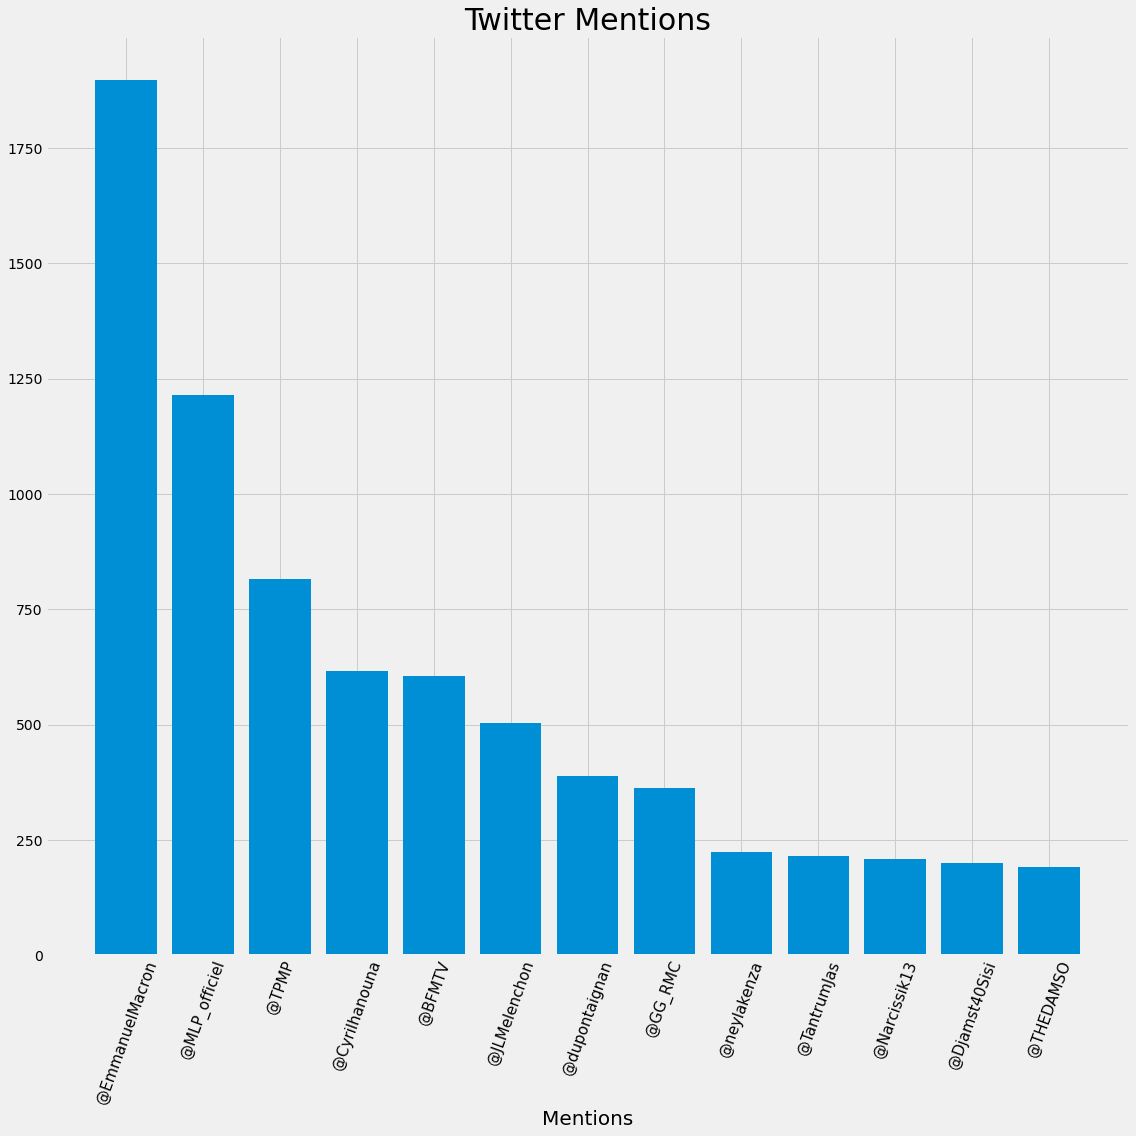

In [91]:
fig, ax = plt.subplots(figsize=(16,16))

tickLoc = np.arange(len(x))
ax.bar(tickLoc, y, width=.8)
ax.set_xticks(ticks=tickLoc)
ax.set_xticklabels([str(i) for i in x], rotation = 70, fontsize=15)
ax.set_xlabel('Mentions', fontsize=20)
ax.set_title('Twitter Mentions', fontsize=30)
plt.savefig('Mentions')
plt.tight_layout()
plt.show()
